# Autoencoder: _Functional API_ with MNIST & TensorFlow 2

In [1]:
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU, LeakyReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
import numpy as np


In [2]:
print(f"TF version: {tf.__version__}")

TF version: 2.6.0


In [3]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU: {gpu_devices}")

GPU: []


In [4]:
if gpu_devices:
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

No GPU found


#### Data preprocessing and cleaning:

In [5]:
# input image dimensions
img_rows, img_cols = 28, 28

In [6]:
# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (28, 28, 1)


In [9]:
# Specify hyper-parameters-
batch_size = 60
num_classes = 10
num_epochs = 100

In [10]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

By default the image data consists of integers between 0 and 255 for each pixel channel. Neural networks work best when each input is inside the range –1 to 1, so we need to divide by 255.

In [11]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [12]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [13]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (60000, 28, 28, 1), y_train.shape: (60000, 10)
X_test.shape: (10000, 28, 28, 1), y_test.shape: (10000, 10)


### Define Autoencoder using _Functional API_ & _Convolutional_ layers

In [14]:
# Specify latent space dimensions-
latent_space_dim = 3

The last conv layer is flattened and connected to a Dense layer of size 2, which represents our 2-D latent space.

In [15]:
# Define encoder-
encoder_input = Input(shape = (28, 28, 1))

x = Conv2D(
    filters = 32, kernel_size = 3,
    strides = 2, padding = 'same')(encoder_input)
x = LeakyReLU()(x)

x = Conv2D(
    filters = 64, kernel_size = 3,
    strides = 2, padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2D(
    filters = 64, kernel_size = 3,
    strides = 1, padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2D(
    filters = 64, kernel_size = 3,
    strides = 1, padding = 'same')(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense(units = latent_space_dim)(x)
# output_layer = LeakyReLU(x)
encoder_output = x

encoder = Model(encoder_input, encoder_output)

In [16]:
# Sanity check-
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0     

In [17]:
# Loop through each trainable layer and print it's shape-
for param in encoder.weights:
    print(f"param.shape: {param.shape}")

param.shape: (3, 3, 1, 32)
param.shape: (32,)
param.shape: (3, 3, 32, 64)
param.shape: (64,)
param.shape: (3, 3, 64, 64)
param.shape: (64,)
param.shape: (3, 3, 64, 64)
param.shape: (64,)
param.shape: (3136, 3)
param.shape: (3,)


In [18]:
# Print randomly initialized weights of first
# filter of first conv layer-
encoder.weights[0][:, :, :, 0]

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[ 0.14011852],
        [-0.11897066],
        [ 0.03588378]],

       [[ 0.01023699],
        [-0.04496475],
        [-0.09630732]],

       [[-0.13938457],
        [-0.05262325],
        [-0.11155124]]], dtype=float32)>

#### Define decoder-
The decoder is a mirror image of the encoder, except instead of convolutional layers, we use convolutional transpose layers.
Note that the decoder doesn’t have to be a mirror image of the encoder. It can be anything you want, as long as the output from the last layer of the decoder is the same size as the input to the encoder (since our loss function will be comparing these pixelwise).


#### Convolutional Transpose Layers:

Standard convolutional layers allow us to halve the size of an input tensor in both height and width, by setting strides = 2.

The convolutional transpose layer uses the same principle as a standard convolutional layer (passing a filter across the image), but is different in that setting strides = 2 'doubles' the size of the input tensor in both height and width.

In a convolutional transpose layer, the 'strides' parameter determines the internal zero padding between pixels in the image.

In Keras, the 'Conv2DTranspose' layer allows us to perform convolutional transpose operations on tensors. By stacking these layers, we can gradually expand the size of each layer, using strides = 2, until we get back to the original image dimension of
28 × 28.


In [19]:
decoder_input = Input(shape = latent_space_dim)

x = Dense(units = 7 * 7 * 64)(decoder_input)
x = Reshape((7, 7, 64))(x)

x = Conv2DTranspose(
    filters = 64, kernel_size = (3, 3),
    strides = (1, 1), padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(
    filters = 64, kernel_size = (3, 3),
    strides = (2, 2), padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(
    filters = 32, kernel_size = (3, 3),
    strides = (2, 2), padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(
    filters = 1, kernel_size = (3, 3),
    strides = (1, 1), padding = 'same')(x)
x = Activation('sigmoid')(x)

decoder_output = x

decoder = Model(decoder_input, decoder_output)

In [20]:
# Sanity check-
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

#### Joining the Encoder to the Decoder
To train the encoder and decoder simultaneously, we need to define a model that will represent the flow of an image through the encoder and back out through the decoder.


In [21]:
# The complete autoencoder-

# The input to the autoencoder is the same as the input to the encoder.
model_input = encoder_input

# The output from the autoencoder is the output from the encoder passed through
# the decoder.
model_output = decoder(encoder_output)

# The Keras model that defines the full autoencoder—a model that takes an image,
# and passes it through the encoder and back out through the decoder to generate
# a reconstruction of the original image.
model = Model(model_input, model_output)

In [22]:
# Final sanity check-
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0   

In [23]:
# Sanity check-
model(X_train[:2, :]).shape

TensorShape([2, 28, 28, 1])

#### Loss function

The loss function is usually chosen to be either-
1. root mean squared error (RMSE) or
1. binary cross-entropy

between the individual pixels of the original image and the reconstruction.

__Binary cross-entropy places heavier penalties on predictions at the extremes that are badly wrong, so it tends to push pixel predictions to the middle of the range. This results in less vibrant images__.

For this reason, author generally prefer to use RMSE as the loss function. However, there is no right or wrong choice — you should choose whichever works best for your use case.

In [56]:
def RMSE_loss(y_true, y_pred):
    # RMSE loss function.
    return K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])


In [57]:
# Compile defined autoencoder model-
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
    loss = RMSE_loss
    # loss = tf.keras.losses.BinaryCrossentropy()
    )

In [58]:
# Define early stopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss', min_delta = 0.0001,
    patience = 4,
    restore_best_weights = True
)
# Adjust 'min_delta' according to training loss for early stopping
# to effectively happen.

In [59]:
print(f"number of training epochs = {num_epochs}")

number of training epochs = 100


In [ ]:
# Train autoencoder-
training_hist = model.fit(
    x = X_train, y = X_train,
    batch_size = batch_size, shuffle = True,
    epochs = num_epochs, callbacks = [early_stopping]
    )

Epoch 1/100
1000/1000 [==============================] - 17s 16ms/step - loss: 0.0631
Epoch 2/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0513
Epoch 3/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0480
Epoch 4/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0461
Epoch 5/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0449
Epoch 6/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0440
Epoch 7/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0434
Epoch 8/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0430
Epoch 9/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0426
Epoch 10/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0423
Epoch 11/100
1000/1000 [==============================] - 16s 16ms/step - loss: 0.0420
Epoch 12/100
1000/1000 [============================

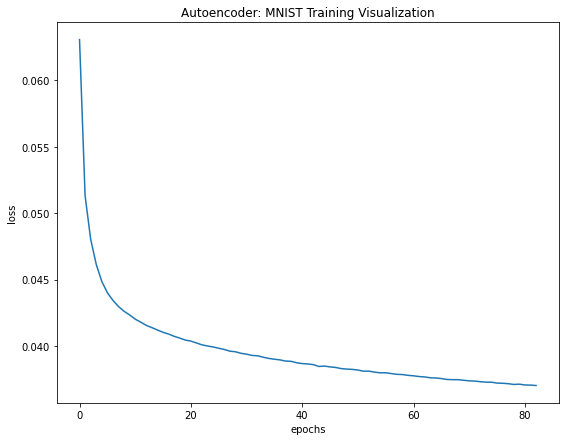

In [ ]:
# Visualize autoencoder training-
# training_hist.history.keys()
# dict_keys(['loss'])

plt.figure(figsize = (9, 7))
plt.plot(training_hist.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Autoencoder: MNIST Training Visualization")
plt.show()

In [ ]:
# Save trained weights-
# model.save_weights("Trained_Autoencoder_MNIST.h5", overwrite = True)

In [60]:
# To load saved weights-
# model.load_weights("Trained_Autoencoder_MNIST.h5")

In [61]:
# Sanity check- Print trained weights of first
# filter of first conv layer-
encoder.weights[0][:, :, :, 0]

<tf.Tensor: shape=(3, 3, 1), dtype=float32, numpy=
array([[[-0.06963216],
        [-0.26576483],
        [-0.07606354]],

       [[ 0.16718596],
        [-0.02057768],
        [-0.09760636]],

       [[ 0.1433656 ],
        [-0.02327649],
        [ 0.07714859]]], dtype=float32)>

### Analysis of _trained_ Autoencoder:

In [62]:
# Get encoded latent space representation for train images-
encoded_X_train = encoder(X_train).numpy()
print(f"encoded_X_train.shape: {encoded_X_train.shape}")

encoded_X_train.shape: (60000, 2)


In [63]:
# Get encoded latent space representations for test images-
encoded_X_test = encoder(X_test).numpy()
print(f"encoded_X_test.shape: {encoded_X_test.shape}")

encoded_X_test.shape: (10000, 2)


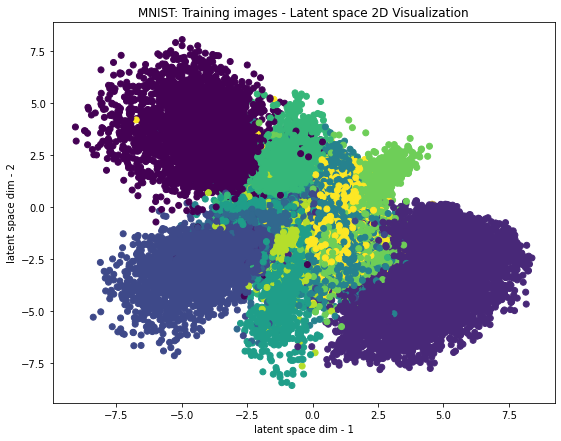

In [64]:
# Visualize latent space of training images-
plt.figure(figsize = (9, 7))
plt.scatter(x = encoded_X_train[:, 0], y = encoded_X_train[:, 1], c = np.argmax(y_train, axis = 1))
# plt.scatter(x = encoded_X_train[:, 0], y = encoded_X_train[:, 1])
plt.xlabel("latent space dim - 1")
plt.ylabel("latent space dim - 2")
plt.title("MNIST: Training images - Latent space 2D Visualization")
plt.show()

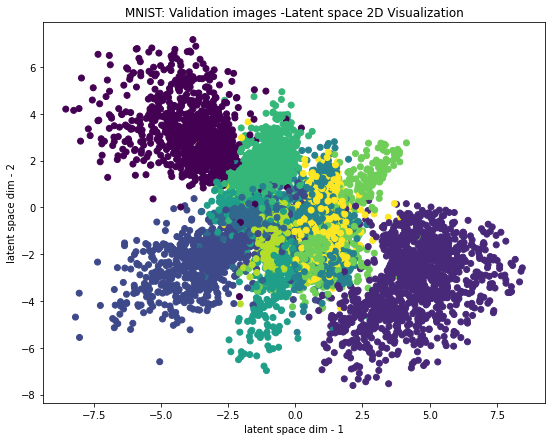

In [65]:
# Visualize latent space of validation images-
plt.figure(figsize = (9, 7))
plt.scatter(x = encoded_X_test[:, 0], y = encoded_X_test[:, 1], c = np.argmax(y_test, axis = 1))
plt.xlabel("latent space dim - 1")
plt.ylabel("latent space dim - 2")
plt.title("MNIST: Validation images -Latent space 2D Visualization")
plt.show()

#### Visualize Actual vs. Recreated MNIST Images
Using trained Autoencoder

In [66]:
recreated_image = model(X_train[:1, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

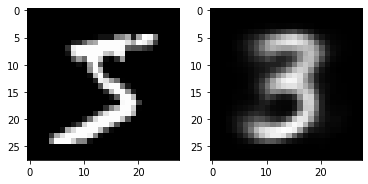

In [67]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[:1, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

In [68]:
recreated_image = model(X_train[100:101, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

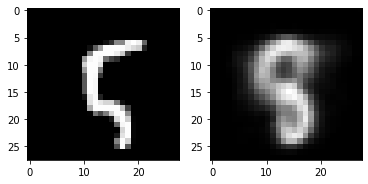

In [69]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[100:101, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

In [70]:
recreated_image = model(X_train[58012:58013, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

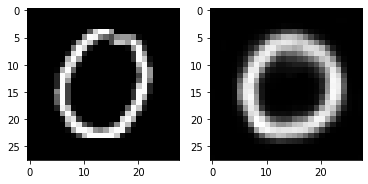

In [71]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[58012:58013, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

In [72]:
recreated_image = model(X_train[45999:46000, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

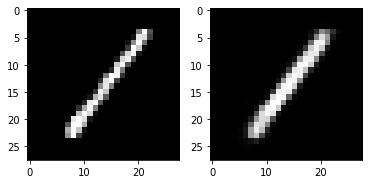

In [73]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[45999:46000, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()

In [74]:
recreated_image = model(X_train[39999:40000, :])
recreated_image = recreated_image.numpy().reshape(28, 28)

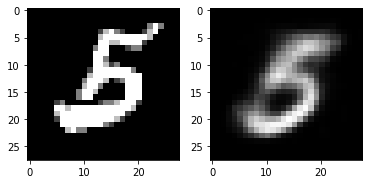

In [75]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(X_train[39999:40000, :].reshape(28, 28), cmap = 'gray')
axarr[1].imshow(recreated_image, cmap = 'gray')
plt.show()